In [520]:
import numpy as np
import matplotlib.pyplot as plt

def create_u_matrix(N1, N2, bc1, bc2):
    N = N1 * N2 # N1 为 a_1 方向 unit cell 数量
    M = np.zeros((2 * N, 2 * N)) # M 储存 u_jk(j 属于 A 子格，k 属于 B 子格)构型
    u = np.zeros((2 * N, 2 * N))
    
    if bc1 == "PBC":
        sign1 = 1
    elif bc1 == "APBC":
        sign1 = -1
    if bc2 == "PBC":
        sign2 = 1
    elif bc2 == "APBC":
        sign2 = -1    
    
    def index(n1, n2, sub):
        return n1 + n2 * N1 + N1 * N2 * sub # A子格对应 sub=0,B子格对应 sub=1
    
    for n2 in range(N2):
        for n1 in range(N1):
            j = index(n1, n2, 0) # j 为(n1, n2)unit cell 内 A 子格格点的单指标
            
            kx = index(n1, n2, 1) # kx 为(n1, n2)unit cell 内 B 子格格点的单指标
            M[j, kx] = 1 # j 与 kx 由 x-bond 相连，一定不跨越边界
            
            ky = index((n1 + 1) % N1, n2, 1) # ky 为 (n1, n2) 往 a1 方向走一步得到的 unit cell 内 B 子格格点的单指标j 与 ky 由 y-bond 相连
            if n1 == N1 - 1:
                M[j, ky] = sign1
            else:
                M[j, ky] = 1

            kz = index(n1, (n2 + 1) % N2, 1) # kz 为 (n1, n2) 往 a2 方向走一步得到的 unit cell 内 B 子格格点的单指标，j 与 kz 由 z-bond 相连
            if n2 == N2 - 1:
                M[j, kz] = sign2
            else:
                M[j, kz] = 1
      
    u = M - M.T                        
    return u

N1, N2, bc1, bc2 = 10, 10, "PBC", "PBC"
N = N1 * N2
u = create_u_matrix(N1, N2, bc1, bc2)
# print(u)



In [521]:
def create_t_matrix(N1, N2, Kx, Ky, Kz, u):
    N = N1 * N2
    t = np.zeros((N, N))
    K = np.array([Kx, Ky, Kz])
    list = np.array([[0, 0], [1, 0], [0, 1]])
    for i in range(N):
        for j in range(N):
            sum = 0
            r_i_vec = np.array([i % N1, i // N1])
            r_j_vec = np.array([j % N1, j // N1])
            
            for delta_vec in list:
                tmp1 = (r_j_vec[0] - delta_vec[0] + N1) % N1
                tmp2 = (r_j_vec[1] - delta_vec[1] + N2) % N2
                if (np.array_equal(r_i_vec,np.array([tmp1, tmp2]))):
                    delta_func = 1
                else:
                    delta_func = 0
                    
                tmp1 = delta_vec[0] + delta_vec[1] * 2
                K_delta = K[tmp1]

                sum += delta_func * K_delta
            sum *= u[i, j + N]
            t[i, j] = sum
    return t
Kx, Ky, Kz = 1, 1, 1

# print(t)
t = create_t_matrix(N1, N2, Kx, Ky, Kz, u)
# print(t)
Xi = -(t + t.T)
# print("Xi:\n", Xi)
Delta = t - t.T
# print("Delta:\n", Delta)

H0_BdG = np.block([
    [Xi, Delta],
    [-Delta, -Xi.T]
])

eigvals, eigvecs = np.linalg.eigh(H0_BdG)
print("eigenvalues:\n", eigvals)
print("eigenvectors:\n", eigvecs)
ground_state_energy = np.sum(eigvals[:N]) / 2
print("ground_state_energy:\n", ground_state_energy)

# print("H0_BdG:\n", H0_BdG)

eigenvalues:
 [-6.         -5.73971009 -5.73971009 -5.73971009 -5.73971009 -5.73971009
 -5.73971009 -5.23606798 -5.23606798 -5.23606798 -5.23606798 -5.23606798
 -5.23606798 -4.99442408 -4.99442408 -4.99442408 -4.99442408 -4.99442408
 -4.99442408 -4.29792228 -4.29792228 -4.29792228 -4.29792228 -4.29792228
 -4.29792228 -4.29792228 -4.29792228 -4.29792228 -4.29792228 -4.29792228
 -4.29792228 -3.88017114 -3.88017114 -3.88017114 -3.88017114 -3.88017114
 -3.88017114 -3.23606798 -3.23606798 -3.23606798 -3.23606798 -3.23606798
 -3.23606798 -3.08672384 -3.08672384 -3.08672384 -3.08672384 -3.08672384
 -3.08672384 -3.08672384 -3.08672384 -3.08672384 -3.08672384 -3.08672384
 -3.08672384 -2.65626205 -2.65626205 -2.65626205 -2.65626205 -2.65626205
 -2.65626205 -2.         -2.         -2.         -2.         -2.
 -2.         -2.         -2.         -2.         -2.         -2.
 -2.         -2.         -2.         -2.         -2.         -2.
 -2.         -2.         -2.         -2.         -2.         

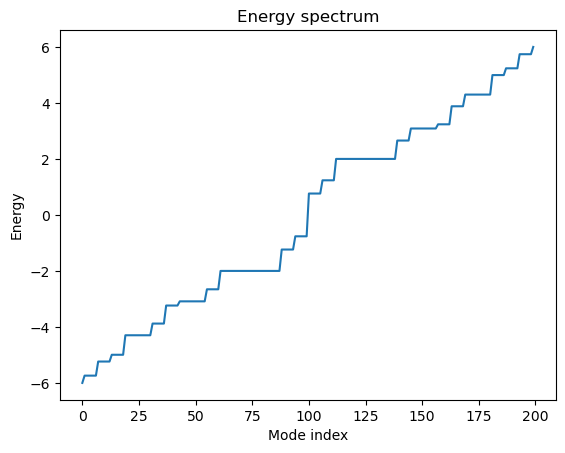

In [522]:
plt.plot(np.arange(len(eigvals)), eigvals, )
plt.xlabel("Mode index")
plt.ylabel("Energy")
plt.title("Energy spectrum")
plt.show()

In [523]:
def create_t_plus_matrix(N1, N2, u):
    N = N1 * N2
    t_plus = np.zeros((N, N))
    def index1(UC_vec, sub):
        return N1 * UC_vec[1] + UC_vec[0] + sub * N
    list1 = [np.array([1, 0]), np.array([0, 1]), np.array([0, 0])]
    list2 = [np.array([0, 1]), np.array([0, 0]), np.array([1, 0])]
    for i in range(N):
        for j in range(N):
            r_i_vec = np.array([i % N1, i // N1])
            r_j_vec = np.array([j % N1, j // N1])
            sum = 0
            
            for delta1_vec, delta2_vec in zip(list1, list2):
                tmp1 = (r_i_vec[0]-delta1_vec[0] + N1) % N1 # r_i - delta_1 的 a_1 分量，考虑了周期性边界条件
                tmp2 = (r_i_vec[1]-delta1_vec[1] + N2) % N2 # r_i - delta_1 的 a_2 分量，考虑了周期性边界条件
                tmp3 = (r_j_vec[0]-delta2_vec[0] + N1) % N1 # r_j - delta_2 的 a_1 分量，考虑了周期性边界条件
                tmp4 = (r_j_vec[1]-delta2_vec[1] + N2) % N2 # r_j - delta_2 的 a_2 分量，考虑了周期性边界条件
                if (np.array_equal(np.array([tmp1, tmp2]) , np.array([tmp3, tmp4]))):
                    delta_func = 1
                else:
                    delta_func = 0
                sum += delta_func * u[index1(r_i_vec, 1), index1(np.array([tmp1, tmp2]), 0) ] * u[index1(r_j_vec, 1), index1(np.array([tmp3, tmp4]), 0)]

            t_plus[i][j] = sum
            
    return t_plus
    
t_plus = create_t_plus_matrix(N1, N2, u)
# print("t_plus:\n", t_plus)

In [524]:
def create_t_minus_matrix(N1, N2, u):
    N = N1 * N2
    t_minus = np.zeros((N, N))
    def index1(UC_vec, sub):
        return N1 * UC_vec[1] + UC_vec[0] + sub * N
    list1 = [np.array([-1, 0]), np.array([0, -1]), np.array([0, 0])]
    list2 = [np.array([0, -1]), np.array([0, 0]), np.array([-1, 0])]
    for i in range(N):
        for j in range(N):
            r_i_vec = np.array([i % N1, i // N1])
            r_j_vec = np.array([j % N1, j // N1])
            sum = 0
            
            for delta1_vec, delta2_vec in zip(list1, list2):
                tmp1 = (r_i_vec[0]-delta1_vec[0] ) % N1 # r_i - delta_1 的 a_1 分量，考虑了周期性边界条件
                tmp2 = (r_i_vec[1]-delta1_vec[1] ) % N2 # r_i - delta_1 的 a_2 分量，考虑了周期性边界条件
                tmp3 = (r_j_vec[0]-delta2_vec[0] ) % N1 # r_j - delta_2 的 a_1 分量，考虑了周期性边界条件
                tmp4 = (r_j_vec[1]-delta2_vec[1] ) % N2 # r_j - delta_2 的 a_2 分量，考虑了周期性边界条件
                if (np.array_equal(np.array([tmp1, tmp2]) , np.array([tmp3, tmp4]))):
                    delta_func = 1
                else:
                    delta_func = 0
                    
                sum += delta_func * u[index1(r_i_vec, 0), index1(np.array([tmp1, tmp2]), 1) ] * u[index1(r_j_vec, 0), index1(np.array([tmp3, tmp4]), 1)]

            t_minus[i][j] = sum
            
    return t_minus
t_minus = create_t_minus_matrix(N1, N2, u)
# print("t_minus:\n", t_minus)

In [525]:
kappa = 0.1
Xi_prime = np.zeros((N, N), dtype = complex)
Delta_prime = np.zeros((N, N), dtype = complex)
Xi_prime = 1j * kappa * (t_plus.T - t_plus + t_minus.T - t_minus)
Delta_prime = 1j * kappa * (t_plus - t_plus.T - (t_minus - t_minus.T))
C_prime = -1j * kappa * np.trace(t_plus + t_minus)
# print("Xi_prime:\n:", Xi_prime)
print("Delta_prime:\n", Delta_prime)
# print("C_prime:\n", C_prime)

Delta_prime:
 [[ 0.+0.j   0.+0.2j  0.+0.j  ...  0.+0.j   0.+0.j   0.+0.j ]
 [-0.-0.2j  0.+0.j   0.+0.2j ...  0.+0.j   0.+0.j   0.+0.j ]
 [ 0.+0.j  -0.-0.2j  0.+0.j  ...  0.+0.j   0.+0.j   0.+0.j ]
 ...
 [ 0.+0.j   0.+0.j   0.+0.j  ...  0.+0.j   0.+0.2j  0.+0.j ]
 [ 0.+0.j   0.+0.j   0.+0.j  ... -0.-0.2j  0.+0.j   0.+0.2j]
 [ 0.+0.j   0.+0.j   0.+0.j  ...  0.+0.j  -0.-0.2j  0.+0.j ]]


In [526]:
H_kappa_BdG = np.block([
    [Xi_prime, Delta_prime],
    [Delta_prime.conj().T, -Xi_prime.T]
]) + C_prime

print("H_kappa_BdG:\n", H_kappa_BdG)

H_kappa_BdG:
 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [527]:
H_total = H0_BdG + H_kappa_BdG
eigvals, eigvecs = np.linalg.eigh(H_total)
print("eigenvalues:\n", eigvals)
print("eigenvectors:\n", eigvecs)
ground_state_energy = np.sum(eigvals[:N]) / 2
print("ground_state_energy:\n", ground_state_energy)

eigenvalues:
 [-6.         -5.73971009 -5.73971009 -5.73971009 -5.73971009 -5.73971009
 -5.73971009 -5.23683806 -5.23683806 -5.23683806 -5.23683806 -5.23683806
 -5.23683806 -4.99442408 -4.99442408 -4.99442408 -4.99442408 -4.99442408
 -4.99442408 -4.30434834 -4.30434834 -4.30434834 -4.30434834 -4.30434834
 -4.30434834 -4.30434834 -4.30434834 -4.30434834 -4.30434834 -4.30434834
 -4.30434834 -3.88017114 -3.88017114 -3.88017114 -3.88017114 -3.88017114
 -3.88017114 -3.27849495 -3.27849495 -3.27849495 -3.27849495 -3.27849495
 -3.27849495 -3.11007804 -3.11007804 -3.11007804 -3.11007804 -3.11007804
 -3.11007804 -3.11007804 -3.11007804 -3.11007804 -3.11007804 -3.11007804
 -3.11007804 -2.65626205 -2.65626205 -2.65626205 -2.65626205 -2.65626205
 -2.65626205 -2.13983304 -2.13983304 -2.13983304 -2.13983304 -2.13983304
 -2.13983304 -2.13983304 -2.13983304 -2.13983304 -2.13983304 -2.13983304
 -2.13983304 -2.05453512 -2.05453512 -2.05453512 -2.05453512 -2.05453512
 -2.05453512 -2.05453512 -2.05453512 

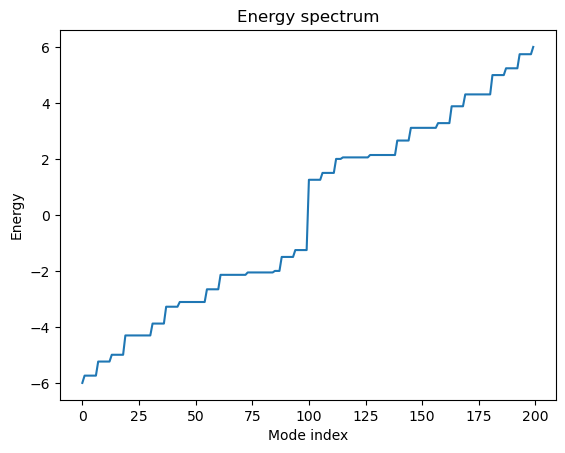

In [528]:
plt.plot(np.arange(len(eigvals)), eigvals, )
plt.xlabel("Mode index")
plt.ylabel("Energy")
plt.title("Energy spectrum")
plt.show()